In [1]:

#from qanta.guesser.wiki_network import *
from functional import seq
import re
import glob
import pickle
import subprocess
import numpy as np
import pandas as pd

In [2]:
import re
import random
import pickle
import string
import numpy as np
from collections import defaultdict
import networkx as nx
import pandas as pd
from nltk.corpus import stopwords
from qanta.util.environment import QB_QUESTION_DB
from qanta.util.qdb import QuestionDatabase


def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

class WikiNetworkGuesser:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        g = nx.DiGraph()
        vertex_set = set()
        page_map = dict()
        params = pickle.load(open('/ssd-c/qanta/best_embs.pkl','rb'), encoding='latin1')
        self.word_emb_multi=params['word_emb_multi']
        self.word_emb_single=params['word_emb_single']
        self.context_emb = params['context_emb']
        vocabs = pickle.load(open('/ssd-c/qanta/wiki_vocabs_p3.pkl', 'rb'))
        self.word_list = vocabs['word_list']
        self.word_index = vocabs['word_index']
        self.reverse_map = vocabs['reverse_map']
        self.multi_words = vocabs['multi_words']
        self.multi_idx_map = vocabs['multi_idx_map']
        self.single_idx_map = vocabs['single_idx_map']
        
        with open('/ssd-c/qanta/titles-sorted.txt') as f:
            for i, line in enumerate(f, 1):
                page = line.strip().lower()
                if re.match("^[a-zA-Z\_']+$", page) and page not in self.stop_words:
                    g.add_node(i, page=page)
                    vertex_set.add(i)
                    page_map[page] = i

        with open('/ssd-c/qanta/links-simple-sorted.txt') as f:
            for line in f:
                source, edges = line.split(':')
                source = int(source)
                if source in vertex_set:
                    edges = [int(vid) for vid in edges.split()]
                    for e in edges:
                        if e in vertex_set:
                            g.add_edge(source, e)
        self.g = g
        self.vertex_set = vertex_set
        self.page_map = page_map
        
        
    def tokenize(self, text):
        raw_words = text.lower().replace(',', '').replace('.', '').split()
        return [w for w in raw_words if w not in self.stop_words]
    
    def emb_tokenize(self, text):
        f = string.punctuation
        f = f.replace("'", '')
        f += '\t\n'
        text = text.translate(str.maketrans(f, ' ' * len(f)))
        raw_words = text.lower().replace(',', '').replace('.', '').split(' ')
        return [w for w in raw_words if w not in self.stop_words and w is not '']

    def generate_guesses(self, text, answer, qnum):
        words = self.tokenize(text)
        seed_vertexes = {self.page_map[w] for w in words if w in self.page_map}
        candidate_vertexes = set()

        for seed_v in seed_vertexes:
            for v in self.g.neighbors(seed_v):
                if v not in seed_vertexes:
                    candidate_vertexes.add(v)

        seed_distances = defaultdict(int)
        for u in candidate_vertexes:
            for v in seed_vertexes:
                try:
                    seed_distances[u] += 1 / nx.shortest_path_length(self.g, source=u, target=v)
                except nx.NetworkXNoPath:
                    seed_distances[u] += 0

        columns = {'vid': [], 'distance': [], 'page': [], 'answer': [], 'qnum': []}

        for vid in candidate_vertexes:
            columns['vid'].append(vid)
            columns['page'].append(self.g.node[vid]['page'])
            columns['distance'].append(seed_distances[vid])
            columns['answer'].append(answer)
            columns['qnum'].append(qnum)

        return pd.DataFrame(columns), seed_vertexes
    
    def generate_guesses_emb(self, text, answer, qnum):
        words = self.tokenize(text)
        seed_vertexes = {self.page_map[w] for w in words if w in self.page_map}
        candidate_vertexes = set()
        cw_id = [self.word_index[w] for w in self.emb_tokenize(text) if self.word_index.get(w)]
        c_emb = np.mean(self.context_emb[cw_id], axis=0)
        
        for seed_v in seed_vertexes:
            for v in self.g.neighbors(seed_v):
                if v not in seed_vertexes:
                    candidate_vertexes.add(v)

        seed_distances = defaultdict(int)
        for u in candidate_vertexes:
            page = self.g.node[u]['page']
            pw_ids = [self.word_index[w] for w in page.split('_') if self.word_index.get(w)]
            v_embs = []
            for wi in pw_ids:
                if self.multi_words.get(wi):
                    s_embs = self.word_emb_multi[self.reverse_map[wi]]
                    prds = np.dot(s_embs, c_emb)
                    v_embs.append(s_embs[np.argmax(prds)])
                else:
                    v_embs.append(self.word_emb_single[self.reverse_map[wi]])
            if len(v_embs) > 0:
                v_embs = np.mean(np.array(v_embs), axis=0)
                seed_distances[u] = sigmoid(np.dot(v_embs, c_emb))
            else:
                seed_distances[u] = 0.0

        columns = {'vid': [], 'distance': [], 'page': [], 'answer': [], 'qnum': []}

        for vid in candidate_vertexes:
            columns['vid'].append(vid)
            columns['page'].append(self.g.node[vid]['page'])
            columns['distance'].append(seed_distances[vid])
            columns['answer'].append(answer)
            columns['qnum'].append(qnum)

        return pd.DataFrame(columns), seed_vertexes

In [3]:
wiki = WikiNetworkGuesser()

In [4]:
db = QuestionDatabase(QB_QUESTION_DB)

Since deep learning does well for questions with many examples, lets only consider questions that have one training example. These would be the most difficult to get correct using traditional learning methods and multi class classification

In [5]:
qs = db.questions_with_pages()
qs_new = seq(qs.values()).filter(lambda x: len(x) == 1).flatten().map(lambda q: q.page).distinct()
qs = seq(qs.values()).filter(lambda x: len(x) == 1).flatten().list()

In [10]:
qs[0].flatten_text()

'One theory regarding this work claims that it was originally performed by Ben and Lew Snowden. It was written as a ""walkaround,"" and the final verse features Will-the-weaver. Abraham (+) Lincoln ordered a performance of this song upon hearing of Robert E. Lee\'s surrender. Disowned by its composer Daniel Decatur Emmett, it was more famously performed by opponents of the (*) Civil Rights movement, and at Jefferson Davis\'s inauguration. For 10 points, name this minstrel song beginning ""I wish I was in the land of cotton"", which has become synonymous with segregation and the Southern US.'

In [12]:
print(qs)

['Oprah Winfrey', 'Wonder Woman', 'Lysimachus', 'Sexual Politics', 'Pataliputra', 'Orange Revolution', 'Under Milk Wood', 'Richard Cromwell', 'U Thant', 'The Emergency (India)', 'The Women of Algiers', 'Alessandro Scarlatti', 'Seattle Mariners', 'A Child of Our Time', 'Buffer overflow', 'President of France', 'Burmese Days', 'Dominican Order', 'Arcturus', 'Premiership of William Gladstone', 'The Invisible Man', 'Shivaji', 'Jenny Lind', 'The Well of Loneliness', 'Paul Krugman', 'Cope reaction', 'Gomez (band)', 'Ferdinand Foch', 'Triangle inequality', 'The Things They Carried', 'Chitty-Chitty-Bang-Bang', 'Otto Stern', 'Fermi surface', 'Washington Monument', 'Karol Szymanowski', 'Sonatas and partitas for solo violin (Bach)', 'The Great Exhibition', 'Justinian II', 'Lady of the Lake', 'And did those feet in ancient time', 'Symphony in C major (Wagner)', 'Mithra', 'Lysosomal storage disease', 'Vigdis Finnbogadottir', 'Stewie Griffin', 'Tom Daschle', 'Cahn-Ingold-Prelog priority rules', 'Ian

In [6]:
df = None
for i, q in enumerate(qs[0:200]):
    if i % 20 == 0:
        print('Starting iteration {}'.format(i))
    guesses, seeds = wiki.generate_guesses_emb(q.flatten_text(), q.page.lower().replace(' ', '_'), q.qnum)
    if df is None:
        df = guesses
    else:
        df = pd.concat([df, guesses])

Starting iteration 0
Starting iteration 20
Starting iteration 40
Starting iteration 60
Starting iteration 80
Starting iteration 100
Starting iteration 120
Starting iteration 140
Starting iteration 160
Starting iteration 180


In [7]:
questions = qs[0:200]

In [9]:
with open('wiki_df.pickle', 'wb') as f:
    pickle.dump(df, f)

In [10]:
possible_questions = []
answer_distances = []
mean_distances = []
norm_mean_distances = []
for q in questions:
    f_df = df[df.qnum == q.qnum]
    answer = f_df['answer'].iloc[0]
    page_set = set(f_df['page'])
    if answer in page_set:
        possible_questions.append(q)
        mean = f_df['distance'].mean()
        std = f_df['distance'].std()
        answer_distance = f_df[f_df.page == answer]['distance'].iloc[0]
        mean_distances.append(mean)
        norm_mean_distances.append((answer_distance - mean) / std)
        answer_distances.append(answer_distance)

In [11]:
print('Mean Overall:', np.mean(mean_distances))
print('Mean Answer:', np.mean(answer_distances))
print('Mean Norm:', np.mean(norm_mean_distances))
print('Std Norm:', np.std(norm_mean_distances))

Mean Overall: 0.0520892600814
Mean Answer: 0.129899445798
Mean Norm: 2.73157464914
Std Norm: 1.66708181417


In [12]:
answer_positions = []
for q in possible_questions:
    f_df = df[df.qnum == q.qnum]
    answer = f_df['answer'].iloc[0]
    answer_distance = f_df[f_df.page == answer]['distance'].iloc[0]
    print('Qnum:', q.qnum)
    print('Answer:', answer)
    print('Answer Distance:', answer_distance)
    print('Mean Distance:', f_df['distance'].mean())
    print('Std Distance:', f_df['distance'].std())
    print('Num Candidates:', len(f_df))
    print('Num to Answer:', len(f_df[f_df.distance >= answer_distance]))
    answer_positions.append(len(f_df[f_df.distance >= answer_distance]))
    print()

Qnum: 212855
Answer: dizzy_gillespie
Answer Distance: 0.136172051858
Mean Distance: 0.054192309906656834
Std Distance: 0.027766288318808313
Num Candidates: 2819
Num to Answer: 5

Qnum: 202967
Answer: atomic_orbital
Answer Distance: 0.238058221392
Mean Distance: 0.0930988413753578
Std Distance: 0.0641254663747806
Num Candidates: 1953
Num to Answer: 23

Qnum: 194521
Answer: ahuitzotl
Answer Distance: 0.0
Mean Distance: 0.04305706096113311
Std Distance: 0.01937147678284384
Num Candidates: 2902
Num to Answer: 2902

Qnum: 197051
Answer: algae
Answer Distance: 0.418864974171
Mean Distance: 0.07413457881693836
Std Distance: 0.07068204094391055
Num Candidates: 1841
Num to Answer: 2

Qnum: 193236
Answer: american_football
Answer Distance: 0.108859006711
Mean Distance: 0.05639271619471719
Std Distance: 0.025143841243345455
Num Candidates: 992
Num to Answer: 34

Qnum: 195803
Answer: amritsar
Answer Distance: 0.131063112283
Mean Distance: 0.047346730025189326
Std Distance: 0.019590454705319338
Num

In [148]:
answer_positions = []
for q in possible_questions:
    f_df = df[df.qnum == q.qnum]
    answer = f_df['answer'].iloc[0]
    answer_distance = f_df[f_df.page == answer]['distance'].iloc[0]
    print('Qnum:', q.qnum)
    print('Answer:', answer)
    print('Answer Distance:', answer_distance)
    print('Mean Distance:', f_df['distance'].mean())
    print('Std Distance:', f_df['distance'].std())
    print('Num Candidates:', len(f_df))
    print('Num to Answer:', len(f_df[f_df.distance >= answer_distance]))
    answer_positions.append(len(f_df[f_df.distance >= answer_distance]))
    print()

Qnum: 212855
Answer: dizzy_gillespie
Answer Distance: 15.65
Mean Distance: 12.687161522998663
Std Distance: 2.692431002623685
Num Candidates: 2819
Num to Answer: 106

Qnum: 202967
Answer: atomic_orbital
Answer Distance: 16.5833333333
Mean Distance: 14.346955843269187
Std Distance: 2.759359815325905
Num Candidates: 1953
Num to Answer: 312

Qnum: 194521
Answer: ahuitzotl
Answer Distance: 16.0595238095
Mean Distance: 15.561693221970556
Std Distance: 2.892540244297074
Num Candidates: 2902
Num to Answer: 1448

Qnum: 197051
Answer: algae
Answer Distance: 14.8166666667
Mean Distance: 9.105566332997096
Std Distance: 1.958924883950674
Num Candidates: 1841
Num to Answer: 1

Qnum: 193236
Answer: american_football
Answer Distance: 8.75
Mean Distance: 6.8016897081413195
Std Distance: 1.4193475029382283
Num Candidates: 992
Num to Answer: 21

Qnum: 195803
Answer: amritsar
Answer Distance: 22.85
Mean Distance: 20.337330852918818
Std Distance: 4.21015766664586
Num Candidates: 3878
Num to Answer: 936

Q

In [13]:

answer_positions = np.array(answer_positions)
n_guesses = [i for i in range(1, 3000)]
recalled = []
for i in n_guesses:
    recalled.append(np.sum(answer_positions <= i))

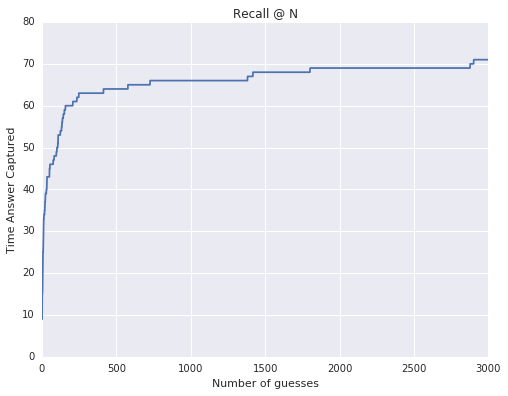

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
f = plt.plot(n_guesses, recalled)
plt.title('Recall @ N')
plt.xlabel('Number of guesses')
plt.ylabel('Time Answer Captured')
plt.gcf().set_size_inches(8, 6)

In [147]:
df[df.qnum == 189749].sort_values('distance', ascending=False)

,answer,distance,page,qnum,vid
3018,mumbai,18.333333,united_kingdom,189749,5300058
208,mumbai,18.200000,mumbai,189749,3481976
2672,mumbai,18.150000,gujarati_language,189749,2071495
894,mumbai,18.150000,philippines,189749,3942619
1548,mumbai,18.033333,england,189749,1601519
217,mumbai,17.983333,kolkata,189749,2777491
2812,mumbai,17.900000,haryana,189749,2153776
2331,mumbai,17.833333,delhi,189749,1341453
2040,mumbai,17.783333,ahmedabad,189749,242843
2069,mumbai,17.600000,geography_of_india,189749,1922280


(array([  2.,   0.,   2.,  12.,  21.,  22.,   8.,   3.,   0.,   1.]),
 array([  0.        ,   3.58833333,   7.17666667,  10.765     ,
         14.35333333,  17.94166667,  21.53      ,  25.11833333,
         28.70666667,  32.295     ,  35.88333333]),
 <a list of 10 Patch objects>)

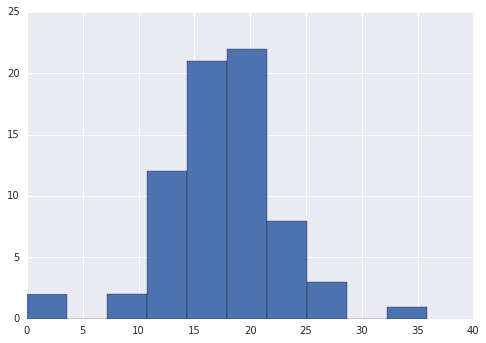

In [108]:
plt.hist(answer_distances)

In [42]:
q = possible_questions[0]
f_df = df[df.qnum == q.qnum]
f_df['distance'].mean()
f_df[f_df.page == q.page]['distance']

IndexError: list index out of range

In [34]:
mean_distances = []
answer_distances = []
for q in possible_questions:
    f_df = df[df.qnum == q.qnum]
    mean_distances.append(f_df['distance'].mean())
    answer_distances.append(f_df[f_df.page == q.page]['distance'][0])
    

IndexError: index out of bounds